# Digital Methods - Word2vec
_____

## Table of Content

1. [Libraries](#libraries)
2. [Cleaning](#cleaning)
3. [Bigrams](#bigrams)
4. [Training the Model](#training-word2vec)
5. [Exploration](#exploration)
6. [Visualisation](#visualization-of-the-embedings)
_____

## Libraries

All libraries which are needed to execute the code are listed here. Install the packages by using the `requirements.txt` file. 

The documentation can be found in the [README.md](README.md) file.

In [1]:
# import packages
import re  
import pandas as pd  
from time import time  
import spacy
from sklearn import *
from gensim.models import Word2Vec
import multiprocessing
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from gensim.models.phrases import Phrases, Phraser
import logging  
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", 
                    datefmt= '%H:%M:%S', level=logging.INFO)

# Cleaning

In this step we will be cleaning the raw text through tlemmatizatin and the removal of stopwords and non-alphabetic characters.

In [2]:
#Load the data
df = pd.read_csv('comments_final.csv')

In [3]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# Custom cleaning function
def cleaning(doc):
    # Lemmatizes and removes stopwords 
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # Return the cleaned text if it has more than 2 tokens
    if len(txt) > 2:
        return ' '.join(txt)
    return ''

In [4]:
# Remove non-alphabetic words
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['text'])


In [5]:
# text cleaning and preprocessing
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

In [6]:
#Removing duplicates and creating the a Data Frame for the duplicates
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()

# Bigrams

This step was implemented since we want to include pairs of wirds into the contextual learning. The meanings in our corpus are also highly dependent on pairs of words such as 'clomate_change', 'fossil _fuel', 'sea_level', etc. By implementing this step, we can gain insights into the relations between words. 

In [7]:
# Ensure all values in 'clean' column are strings and handle NaN values
df_clean['clean'] = df_clean['clean'].astype(str).fillna('')

# Tokenize the sentences
sent = [row.split() for row in df_clean['clean']]

In [8]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 20:40:10: collecting all words and their counts
INFO - 20:40:10: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:40:10: PROGRESS: at sentence #10000, processed 116072 words and 92798 word types
INFO - 20:40:10: PROGRESS: at sentence #20000, processed 326085 words and 240350 word types
INFO - 20:40:10: PROGRESS: at sentence #30000, processed 446370 words and 313152 word types
INFO - 20:40:10: PROGRESS: at sentence #40000, processed 599266 words and 399876 word types
INFO - 20:40:11: PROGRESS: at sentence #50000, processed 774319 words and 494998 word types
INFO - 20:40:11: PROGRESS: at sentence #60000, processed 979272 words and 605609 word types
INFO - 20:40:11: PROGRESS: at sentence #70000, processed 1130840 words and 677729 word types
INFO - 20:40:11: PROGRESS: at sentence #80000, processed 1304463 words and 757252 word types
INFO - 20:40:11: collected 782194 token types (unigram + bigrams) from a corpus of 1355605 words and 84459 sentences
INFO - 20:40:

In [9]:
# create bigram
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 20:40:11: exporting phrases from Phrases<782194 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 20:40:12: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<613 phrases, min_count=30, threshold=10.0> from Phrases<782194 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.78s', 'datetime': '2024-05-28T20:40:12.378202', 'gensim': '4.3.2', 'python': '3.11.1 (v3.11.1:a7a450f84a, Dec  6 2022, 15:24:06) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'created'}


# Training Word2Vec

Setting up model parameters.

In [10]:
# setting up the model
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

# parameters for word to vec model
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 20:40:12: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2024-05-28T20:40:12.383836', 'gensim': '4.3.2', 'python': '3.11.1 (v3.11.1:a7a450f84a, Dec  6 2022, 15:24:06) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'created'}


Creating a vocabulary table for encoding words as indices and later looking up their corresponding word embeddings during interpretation. 

In [11]:
# build vocabulary based on the bigrams
w2v_model.build_vocab(sentences, progress_per=10000)

INFO - 20:40:12: collecting all words and their counts
INFO - 20:40:12: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:40:12: PROGRESS: at sentence #10000, processed 109249 words, keeping 11943 word types
INFO - 20:40:12: PROGRESS: at sentence #20000, processed 308022 words, keeping 21391 word types
INFO - 20:40:12: PROGRESS: at sentence #30000, processed 421621 words, keeping 25520 word types
INFO - 20:40:12: PROGRESS: at sentence #40000, processed 565876 words, keeping 29306 word types
INFO - 20:40:12: PROGRESS: at sentence #50000, processed 731495 words, keeping 33103 word types
INFO - 20:40:13: PROGRESS: at sentence #60000, processed 926570 words, keeping 37477 word types
INFO - 20:40:13: PROGRESS: at sentence #70000, processed 1070057 words, keeping 39984 word types
INFO - 20:40:13: PROGRESS: at sentence #80000, processed 1232387 words, keeping 42875 word types
INFO - 20:40:13: collected 44036 word types from a corpus of 1280561 raw words and 84459 sen

After defining the model's parameters and indexing the tokens, we now feed the corpus of text into the algorithm. 

In [12]:
# train model based on bigrams
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

INFO - 20:40:13: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 6399 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2024-05-28T20:40:13.323111', 'gensim': '4.3.2', 'python': '3.11.1 (v3.11.1:a7a450f84a, Dec  6 2022, 15:24:06) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'train'}
INFO - 20:40:14: EPOCH 0 - PROGRESS: at 74.75% examples, 483180 words/s, in_qsize 11, out_qsize 4
INFO - 20:40:14: EPOCH 0: training on 1280561 raw words (642938 effective words) took 1.2s, 551741 effective words/s
INFO - 20:40:15: EPOCH 1 - PROGRESS: at 63.20% examples, 409705 words/s, in_qsize 10, out_qsize 3
INFO - 20:40:15: EPOCH 1: training on 1280561 raw words (642111 effective words) took 1.3s, 492502 effective words/s
INFO - 20:40:16: EPOCH 2 - PROGRESS: at 64.19% examples, 423054 words/s, in_qsize 12, out_qsize 3
INFO - 20:40:17: EPOCH 2: training on 1280561 raw words (64

(19279453, 38416830)

In [13]:
w2v_model.init_sims(replace=True)

/var/folders/0t/kqk1ph5n4ds0_g7v6gyknwdh0000gn/T/ipykernel_2131/514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
WARNING - 20:40:56: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


# Exploration

In [14]:
# use words from open coding and topic modelling based for claims to find similar words
claims = {
    "Claim 1": ["non_existent","untrue","global_warming"],
    "Claim 2": ["climate_change","co", "global_warming"],
    "Claim 3": ["climate_change", "healthy", "plant_food", "plant_growth"],
    "Claim 4": ["policymaker", "policy", "green_energy", "renewable_energy", "energy_source", "clean_energy", "energy_production", "energy_sector"],
    "Claim 5": ["climate_alarmism", "climate_alarmist", "alarmism", "exaggeration"],
    "Claim 6": ["climate_change","expert", "expertise", "knowledgeable", "corrupt_politician"],
    "Claim 7": ["climate_change","woman_child", "childhood", "globalist", "global_cooling", "globalism"]
}

In [15]:
# Loop through each claim and its words
for claim, words in claims.items():
    combined_words = words  # Combine all words in the claim
    try:
        similar_words = w2v_model.wv.most_similar(positive=combined_words)
        print(f"\nSimilar words for all words in {claim}:")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity}")
    except KeyError:
        print(f"Some words in {claim} are not in the vocabulary.")


Similar words for all words in Claim 1:
  climate_change: 0.6981297135353088
  climate_crisis: 0.6315183043479919
  anthropomorphic: 0.6078851222991943
  human_cause: 0.5840146541595459
  alarmist: 0.573114275932312
  proponent: 0.572528600692749
  exaggerated: 0.555868923664093
  phenomena: 0.5465553402900696
  feedback_loop: 0.5425977110862732
  assert: 0.5354793071746826

Similar words for all words in Claim 2:
  warming: 0.7102347016334534
  human_cause: 0.6960341930389404
  negligible: 0.6856388449668884
  anthropomorphic: 0.6779686808586121
  anthropogenic: 0.6357219219207764
  lag: 0.6288163661956787
  natural_process: 0.6279937028884888
  natural_cycle: 0.6200858354568481
  greenhouse_gas: 0.6187764406204224
  causal: 0.6091427803039551

Similar words for all words in Claim 3:
  co: 0.6893352270126343
  trace_gas: 0.6823365092277527
  greener: 0.6762478351593018
  plant_life: 0.6592142581939697
  plant_animal: 0.6284487247467041
  human: 0.6175309419631958
  optimal: 0.6102743

## Visualization of the embedings

In [16]:
# Get all the word vectors
word_vectors = w2v_model.wv

# Extract the vectors
vectors = word_vectors.vectors

In [17]:
#creating 2D vector for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

#creating 3D vector for 3D visualization
tsne_3d = TSNE(n_components=3, random_state=42)
vectors_3d = tsne_3d.fit_transform(vectors)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


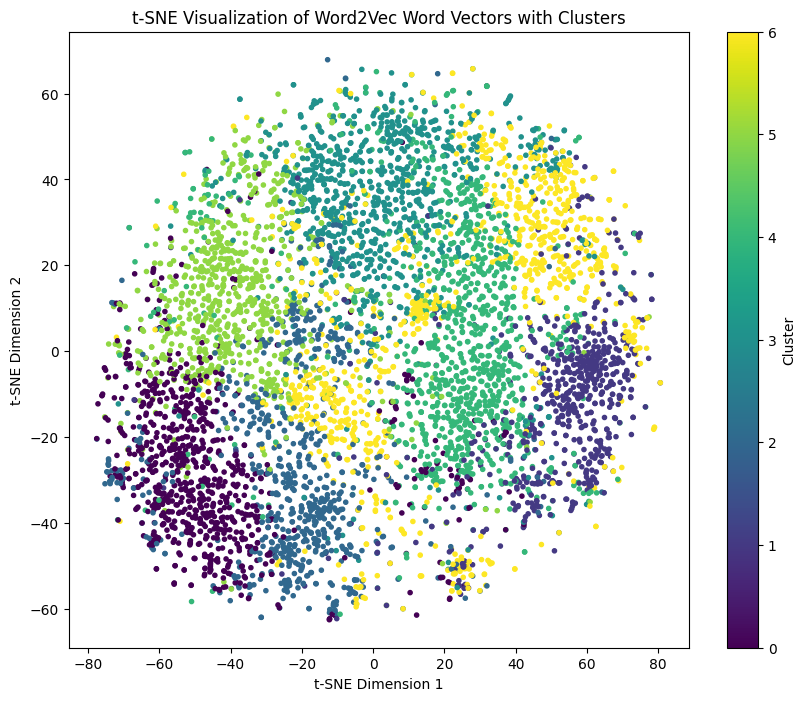

Cluster 1 words: ['year', 'time', 'co', 'earth', 'change', 'cause', 'happen', 'human', 'temperature', 'planet', 'global_warming', 'weather', 'end', 'mean', 'long', 'warm', 'increase', 'high', 'heat', 'actually', 'effect', 'global', 'atmosphere', 'far', 'sun', 'c', 'today', 'ocean', 'show', 'level', 'rise', 'history', 'record', 'cool', 'air', 'low', 'degree', 'yes', 'course', 'ice_age', 'natural', 'result', 'different', 'current', 'number', 'decade', 'explain', 'study', 'include', 'period', 'warming', 'mention', 'guess', 'small', 'cycle', 'past', 'add', 'average', 'carbon_dioxide', 'total', 'affect', 'event', 'solar', 'nature', 'possible', 'age', 'predict', 'zero', 'impact', 'experience', 'bit', 'expect', 'greenhouse_gas', 'figure', 'k', 'space', 'surface', 'temp', 'suppose', 'rate', 'second', 'begin', 'mass', 'major', 'sea_level', 'difference', 'accord', 'e', 'likely', 'ppm', 'graph', 'drop', 'reach', 'short', 'measure', 'release', 'influence', 'cloud', 'radiation', 'compare', 'factor'

In [18]:
# Perform K-means clustering
num_clusters = 7  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors)

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=cluster_labels, cmap='viridis', marker='.')
plt.title('t-SNE Visualization of Word2Vec Word Vectors with Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

# Get main words in each cluster
words = list(word_vectors.index_to_key)
word_clusters = [[] for _ in range(num_clusters)]
for i, word in enumerate(words):
    word_clusters[cluster_labels[i]].append(word)

# Print main words in each cluster
for i, cluster in enumerate(word_clusters):
    print(f'Cluster {i+1} words:', cluster)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


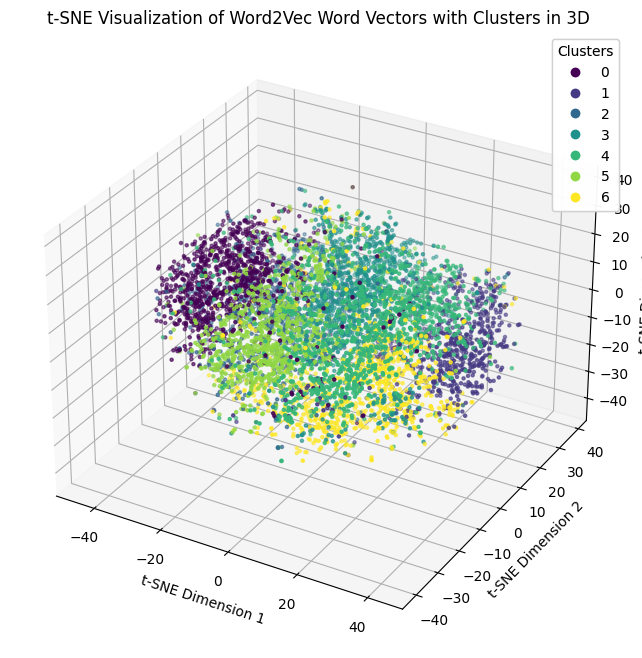

Cluster 1 words: ['year', 'time', 'co', 'earth', 'change', 'cause', 'happen', 'human', 'temperature', 'planet', 'global_warming', 'weather', 'end', 'mean', 'long', 'warm', 'increase', 'high', 'heat', 'actually', 'effect', 'global', 'atmosphere', 'far', 'sun', 'c', 'today', 'ocean', 'show', 'level', 'rise', 'history', 'record', 'cool', 'air', 'low', 'degree', 'yes', 'course', 'ice_age', 'natural', 'result', 'different', 'current', 'number', 'decade', 'explain', 'study', 'include', 'period', 'warming', 'mention', 'guess', 'small', 'cycle', 'past', 'add', 'average', 'carbon_dioxide', 'total', 'affect', 'event', 'solar', 'nature', 'possible', 'age', 'predict', 'zero', 'impact', 'experience', 'bit', 'expect', 'greenhouse_gas', 'figure', 'k', 'space', 'surface', 'temp', 'suppose', 'rate', 'second', 'begin', 'mass', 'major', 'sea_level', 'difference', 'accord', 'e', 'likely', 'ppm', 'graph', 'drop', 'reach', 'short', 'measure', 'release', 'influence', 'cloud', 'radiation', 'compare', 'factor'

In [19]:
# Perform K-means clustering
num_clusters = 7  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors)

# Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], c=cluster_labels, cmap='viridis', marker='.')
ax.set_title('t-SNE Visualization of Word2Vec Word Vectors with Clusters in 3D')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

# Get main words in each cluster
word_clusters = [[] for _ in range(num_clusters)]
for i, word in enumerate(words):
    word_clusters[cluster_labels[i]].append(word)

# Print main words in each cluster
for i, cluster in enumerate(word_clusters):
    print(f'Cluster {i+1} words:', cluster)